Импорт библиотек

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Анализ структуры данных и их предобработка

Чтение датасета

In [118]:
df = pd.read_csv('sem2/ml_ops/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


В данных отсутствуют пропуски. Присутствуют признаки типов bool(1), int64(4), object(2). Признак Unnamed: 0 похож на индекс, проверим:

In [120]:
(df['Unnamed: 0'].values == range(len(df))).all()

np.True_

Верно, можно удалить этот признак. Также преобразуем строковые типы в категориальные, а булевый в числовой

In [121]:
df = df.drop('Unnamed: 0', axis=1)
df['test group'] = df['test group'].astype('category')
df['most ads day'] = df['most ads day'].astype('category')
df['converted'] = df['converted'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user id        588101 non-null  int64   
 1   test group     588101 non-null  category
 2   converted      588101 non-null  int64   
 3   total ads      588101 non-null  int64   
 4   most ads day   588101 non-null  category
 5   most ads hour  588101 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 19.1 MB


Проверим наличие пользователей которые попали в обе группы

In [122]:
users_with_multiple_groups = df.groupby('user id')['test group'].nunique()
users_with_multiple_groups[users_with_multiple_groups > 1]

Series([], Name: test group, dtype: int64)

Таких пользователей нет, оставляем все как есть

# Первичный анализ результатов A/B-тестирования

Посчитаем количество посещений сайта и суммарное количество совершённых покупок по группам

In [123]:
group_stats = df.groupby('test group').agg(
    visits=('user id', 'count'),
    total_purchases=('converted', 'sum')
)
group_stats

C:\Users\ССС ССС\AppData\Local\Temp\ipykernel_157300\721303036.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('test group').agg(


,visits,total_purchases
test group,,
ad,564577,14423
psa,23524,420


Количество посещений сильно не сбалансированно, в экспериментальной группе их на порядок больше.

Расситаем конверсию и среднее количество рекламы, увиденной пользователем.

In [124]:
group_stats['conversion'] = group_stats['total_purchases'] / group_stats['visits'] * 100
group_stats['mean ads'] = df.groupby('test group')['total ads'].mean()
group_stats

C:\Users\ССС ССС\AppData\Local\Temp\ipykernel_157300\3741629971.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats['mean ads'] = df.groupby('test group')['total ads'].mean()


,visits,total_purchases,conversion,mean ads
test group,,,,
ad,564577,14423,2.554656,24.823365
psa,23524,420,1.785411,24.761138


При практически одинаковом количестве показов рекламы в экспериментальной группе конверсия значительно выше

# Статистический анализ результатов A/B-тестирования

Будем использовать z-тест для проверки гипотезы о равенстве конверсий в двух группах.

Нулевая гипотеза (H₀): Конверсия в группе ad равна конверсии в группе psa.

Альтернативная гипотеза (H₁): Конверсия в группе ad не равна конверсии в группе psa.

In [125]:
# разделим группы
group_a = df[df['test group'] == 'ad']
group_b = df[df['test group'] == 'psa']

# количество успехов и общее число наблюдений
success_a = group_a['converted'].sum()
success_b = group_b['converted'].sum()
n_a = group_a.shape[0]
n_b = group_b.shape[0]

# Пропорции
p_a = success_a / n_a
p_b = success_b / n_b
p_pooled = (success_a + success_b) / (n_a + n_b)

# z-тест для сравнения пропорций
z_score = (p_a - p_b) / np.sqrt(p_pooled * (1 - p_pooled) * (1/n_a + 1/n_b))
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

print(f"z-тест: z = {z_score:.4f}, p_value = {p_value:.4f}")

z-тест: z = 7.3701, p_value = 0.0000


При уровне значимости 0.05 отвергаем нулевую гипотезу в пользу альтернативной. Конверсии в группах отличаются

Проверим нормальность распределения среднего количества рекламы с помощью теста Шапиро-Уилка.

Нулевая гипотеза (H₀): Среднее количество показов рекламы в группы ad и группы psa нормальны.

Альтернативная гипотеза (H₁): Среднее количество показов рекламы группы ad и группы psa не нормальны.

In [126]:
# Проверка нормальности
_, p_norm_a = stats.shapiro(group_a['total ads'])
_, p_norm_b = stats.shapiro(group_b['total ads'])

print("p_value ad:", stats.shapiro(group_a['total ads'])[1])
print("p_value psa:", stats.shapiro(group_b['total ads'])[1])

p_value ad: 3.701044472444164e-203
p_value psa: 7.270789402370636e-120


C:\ProgramData\anaconda3\envs\data_analysis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 564577.
  res = hypotest_fun_out(*samples, **kwds)
C:\ProgramData\anaconda3\envs\data_analysis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23524.
  res = hypotest_fun_out(*samples, **kwds)


При уровне значимости 0.05 отвергаем нулевую гипотезу для обеих групп в пользу альтернативной. Распределения отличаются от нормального.

Далее используем U-тест

Нулевая гипотеза (H₀): Среднее количество показов рекламы в группе ad и группе ad совпадают.

Альтернативная гипотеза (H₁): Среднее количество показов рекламы в группе ad и группе ad не совпадают.

In [127]:
# вычисляем результат U-теста
test_stat, p_ads = stats.mannwhitneyu(
    group_a['total ads'],
    group_b['total ads'],
    alternative='two-sided'
)

print('p_value:', p_ads)

p_value: 4.6909108547205694e-11


При уровне значимости 0.05 отвергаем нулевую гипотезу в пользу альтернативной. Среднее количество показов рекламы в группе ad и группе ad не совпадают

Постоим доверительные 95% интервалы для:

* конверсий в каждой из групп
* разницы конверсий в группах
* среднего количества увиденной рекламы в группах ad и psa.

In [128]:
# функция для рассчета доверительного интервала для пропорции
def proportion_ci(successes, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -stats.norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (successes * (1 - successes) / n) ** 0.5
    return successes - eps, successes + eps

In [129]:
lower_ad, upper_ad  = proportion_ci(
    successes=group_a['converted'].mean(), # выборочная пропорция
    n=group_a['user id'].count() # размер выборки
)

lower_psa, upper_psa  = proportion_ci(
    successes=group_b['converted'].mean(), # выборочная пропорция
    n=group_b['user id'].count() # размер выборки
)

l = lambda x: round(float(x) * 100, 2)

print(f'С вероятностью 95% в группе ad значение конверсии лежит в интервале между {l(lower_ad)} и {l(upper_ad)}')
print(f'С вероятностью 95% в группе psa значение конверсии лежит в интервале между {l(lower_psa)} и {l(upper_psa)}')

С вероятностью 95% в группе ad значение конверсии лежит в интервале между 2.51 и 2.6
С вероятностью 95% в группе psa значение конверсии лежит в интервале между 1.62 и 1.95


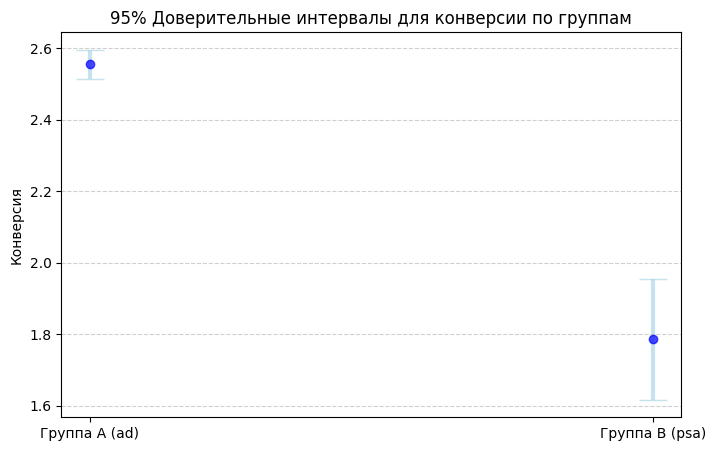

In [130]:
# Успехи и размеры
success_a = group_a['converted'].sum()
success_b = group_b['converted'].sum()
n_a = group_a.shape[0]
n_b = group_b.shape[0]

# Средние значения (для точек)
mean_ad = success_a / n_a
mean_psa = success_b / n_b

# Построение графика
labels = ['Группа A (ad)', 'Группа B (psa)']
means = [mean_ad * 100, mean_psa * 100]
errors = [
    (mean_ad - lower_ad) * 100,
    (mean_psa - lower_psa) * 100
]

plt.figure(figsize=(8, 5))
plt.errorbar(labels, means, yerr=errors, capsize=10, fmt='o', color='blue', ecolor='lightblue', elinewidth=3, alpha=0.7)
plt.ylabel('Конверсия')
plt.title('95% Доверительные интервалы для конверсии по группам')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [131]:
# функция для рассчета доверительного интервала для разности пропорций
def proportion_diff_ci(successes, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    diff = successes[1] - successes[0]
    z_crit = -stats.norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (successes[0] * (1 - successes[0])/n[0] + successes[1] * (1 - successes[1])/n[1]) ** 0.5
    return diff - eps, diff + eps

In [132]:
# доверительный интервал для разности пропорций
lower_bound, upper_bound = proportion_diff_ci(
    successes=[group_a['converted'].mean(), group_b['converted'].mean()],
    n=[group_a['user id'].count(), group_b['user id'].count()]
)

l = lambda x: round(float(x) * 100, 2)

# выводим результат
print(f'С вероятностью 95% разность конверсий лежит в интервале между {l(lower_bound)} и {l(upper_bound)}')

С вероятностью 95% разность конверсий лежит в интервале между -0.94 и -0.6


С вероятностью 95% конверсия в ad будет выше чем в psa

95% доверительный интервал для группы ad: [24.71, 24.94]
95% доверительный интервал для группы psa: [24.21, 25.31]


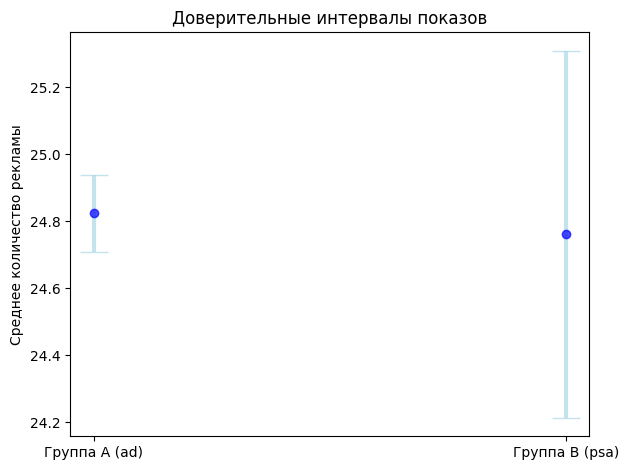

In [ ]:
mean_a = group_a['total ads'].mean()
mean_b = group_b['total ads'].mean()
stde_a = group_a['total ads'].std(ddof=1) / np.sqrt(n_a)
stde_b = group_b['total ads'].std(ddof=1) / np.sqrt(n_b)

# Доверительные интервалы количества рекламы
lower_a = (mean_a - 1.96 * stde_a, mean_a + 1.96 * stde_a)
lower_b = (mean_b - 1.96 * stde_b, mean_b + 1.96 * stde_b)

l = lambda x: round(float(x), 2)

print(f"95% доверительный интервал для группы ad: {list(map(l, lower_a))}")
print(f"95% доверительный интервал для группы psa: {list(map(l, lower_b))}")

plt.errorbar([0, 1], [mean_a, mean_b],
            yerr=[mean_a - lower_a[0], mean_b - lower_b[0]],
            capsize=10, fmt='o', color='blue', ecolor='lightblue', elinewidth=3, alpha=0.7
)
plt.xticks([0, 1], ['Группа A (ad)', 'Группа B (psa)'])
plt.ylabel('Среднее количество рекламы')
plt.title('Доверительные интервалы показов')
plt.tight_layout()
plt.show()

Доверительные интервалы значительно близки. Можно сказать что общее среднее количество рекламы с вероятностью 95% будет лежать в интервале (24.71, 24.94).

# Вывод

Согласно проведенному исследованию можно сделать вывод, что рекламная компания была успешной и привела к увеличению средней конверсии с вероятностью 95% на 0.6 - 0.94 при отсутствии значительных различий в количестве показов рекламы. Можно сказать, что успех можно объяснить рекламой, а не другими факторами.